In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import scipy
import astropy
import tqdm

## Load data

In [3]:
def data_scope(arr, t_arr, t_start, t_stop):
    idxs = np.where((t_arr >= t_start) & (t_arr <= t_stop))[0]
    return arr[idxs]

def spike_scope(spikes, t_arr):
    hists = []
    for spike_train in spikes.item().values():
        hist, _ = np.histogram(spike_train, bins=np.append(t_arr, t_arr[-1] + t_arr[1] - t_arr[0]))
        hists.append(hist)
    hists = np.array(hists)
    return hists

In [4]:
data_path = '/Users/vemundss/Desktop/Toroidal_topology_grid_cell_data/'

In [5]:
with open(data_path + 'rat_q_sessions.txt') as file:
#with open(data_path + 'rat_r_day1_sessions.txt') as file:
#with open(data_path + 'rat_r_day2_sessions.txt') as file:
#with open(data_path + 'rat_s_sessions.txt') as file:
    sessions = file.readlines()
sessions

['#1,  sleep_box_1,        start=9576, end=18812   \n',
 '#2,  wagon_wheel_1,      start=18977, end=25355   \n',
 '#3,  sleep_box_2,        start=25403, end=27007   \n',
 '#4,  open_field_1,       start=27826, end=31223   \n']

In [6]:
data = {}

In [7]:
f = np.load(data_path + 'rat_q_grid_modules_1_2.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']

t_start, t_stop = 27826, 31223
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)

data['rat_q'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2}}

In [8]:
f = np.load(data_path + 'rat_r_day1_grid_modules_1_2_3.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']
spikes3 = f['spikes_mod3']

t_start, t_stop = 7457, 14778
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)
spikes3 = spike_scope(f['spikes_mod3'], t)

data['rat_r_day1'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2, 3: spikes3}}

# can add second slice (valid times) 14890, 16045 here

In [9]:
f = np.load(data_path + 'rat_r_day2_grid_modules_1_2_3.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']
spikes2 = f['spikes_mod2']
spikes3 = f['spikes_mod3']

t_start, t_stop = 10617, 13004
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)
spikes2 = spike_scope(f['spikes_mod2'], t)
spikes3 = spike_scope(f['spikes_mod3'], t)

data['rat_r_day2'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1, 2: spikes2, 3: spikes3}}

In [10]:
f = np.load(data_path + 'rat_s_grid_modules_1.npz', allow_pickle=True)
x = f['x']
y = f['y']
t = f['t']
spikes1 = f['spikes_mod1']

t_start, t_stop = 9939, 12363
x = data_scope(f['x'], f['t'], t_start, t_stop)
y = data_scope(f['y'], f['t'], t_start, t_stop)
t = data_scope(f['t'], f['t'], t_start, t_stop)
spikes1 = spike_scope(f['spikes_mod1'], t)

data['rat_s'] = {'x': x, 'y': y, 't': t, 'modules': {1: spikes1}}

## Create ratemaps

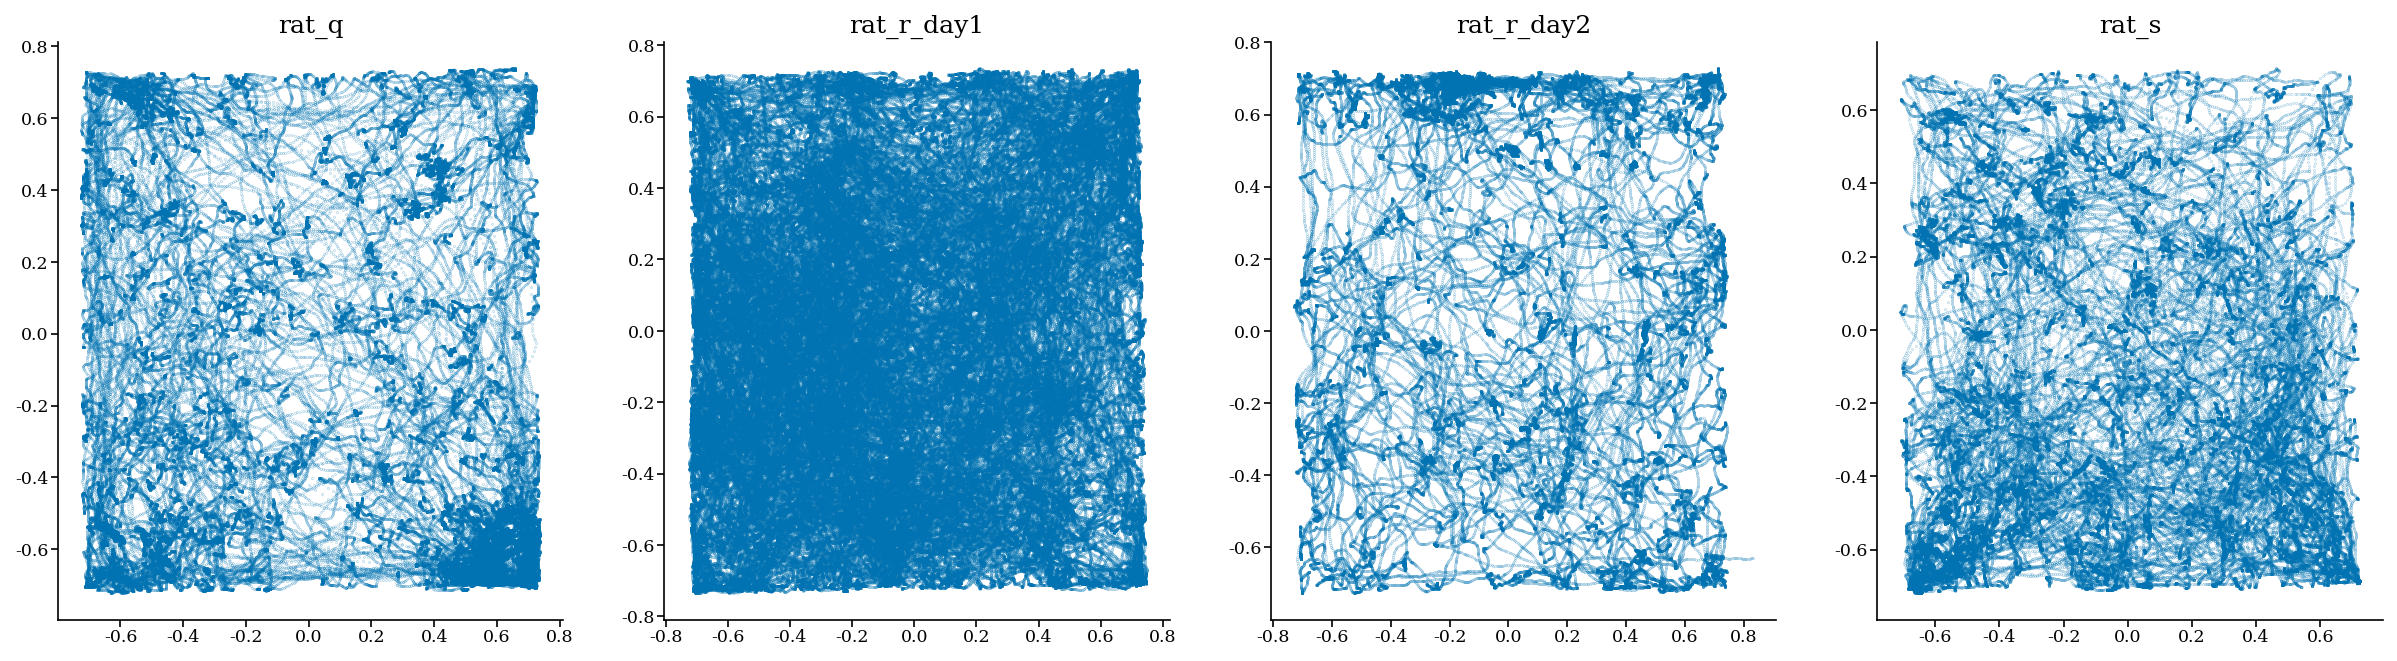

In [11]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
for i, (rat, rat_data) in enumerate(data.items()):
    axs[i].scatter(rat_data['x'], rat_data['y'], s=0.01)
    axs[i].set_title(rat)

In [121]:
res = 32
all_ratemaps = []
for rat_i, data_i in data.items():
    x, y = data_i['x'], data_i['y']
    for module_j, spikes_j in data_i['modules'].items():
        ratemaps_ij = scipy.stats.binned_statistic_2d(x, y, spikes_j, bins=res).statistic
        all_ratemaps.append(ratemaps_ij)
        print(rat_i, module_j, len(ratemaps_ij))

rat_q 1 97
rat_q 2 66
rat_r_day1 1 166
rat_r_day1 2 168
rat_r_day1 3 149
rat_r_day2 1 189
rat_r_day2 2 172
rat_r_day2 3 183
rat_s 1 140


## Calculate grid statistics

In [122]:
import spatial_maps as sm
grid_threshold = 0.4 # <----------------- threshold for gridness score
ratemaps = all_ratemaps[2] # <----------------- select grid module
ratemaps = np.array([astropy.convolution.convolve(ratemaps[i], astropy.convolution.Gaussian2DKernel(2), boundary='wrap') for i in range(ratemaps.shape[0])])

center_peaks = np.array([sm.find_peaks(ratemaps[i])[0] for i in range(ratemaps.shape[0])])
grid_scores = np.array([sm.gridness(ratemap) for ratemap in ratemaps])
acorrs = np.array([sm.autocorrelation(ratemap) for ratemap in ratemaps])
peaks = [sm.find_peaks(acorr) for acorr in acorrs]
thetas = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[1] for peak in peaks])
spacings = np.array([sm.spacing_and_orientation(peak, acorrs.shape[-1])[0] for peak in peaks])
# get the most common spacing and theta
bins=25
hist, bin_edges = np.histogram(spacings, bins=bins)
spacing = bin_edges[np.argmax(hist)] + (bin_edges[1] - bin_edges[0])/2
hist, bin_edges = np.histogram(thetas, bins=bins)
theta = bin_edges[np.argmax(hist)] + (bin_edges[1] - bin_edges[0])/2

from methods import Hexagon, HexagonalGCs
f = 2/(np.sqrt(3)*spacing)
#radius = spacing/np.sqrt(3) # spacing is peak-to-peak distance
radius = 2/(3*f)
orientation = theta*180/np.pi - 15 # theta is angle from x-axis
hexagon = HexagonalGCs(f=f, init_rot=orientation)

# mask out non-grid cells
mask = grid_scores > grid_threshold
mask = hexagon.unit_cell.is_in_hexagon(center_peaks-res/2) & mask
print("n=",(mask).sum(), ", N=",len(mask))

# remove stats based on phases outside hexagon and grid scores below threshold
center_peaks = center_peaks[mask]
ratemaps = ratemaps[mask]
thetas = thetas[mask]
spacings = spacings[mask]
grid_scores = grid_scores[mask]

# set phases to hexagon
hexagon.set_phases(center_peaks-res/2) # WRAPPY?

# create random hexagon baseline
random_hexagon = HexagonalGCs(f=f, init_rot=orientation)
random_hexagon.set_phases(random_hexagon.unit_cell.wrap(np.around(random_hexagon.unit_cell.sample(len(center_peaks)))))
print(f"Radius: {radius}, Orientation: {orientation}")

n= 105 , N= 166
Radius: 7.102767803117687, Orientation: -7.130993247402021


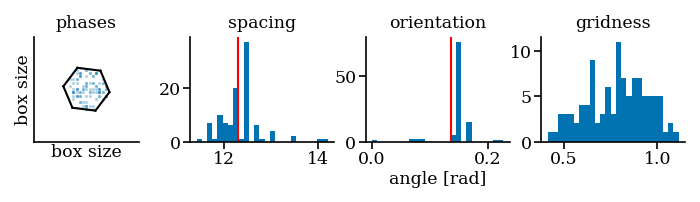

In [134]:
fig, axs = plt.subplots(ncols=4, figsize=(4.6,1.15))
axs[0].scatter(*(center_peaks-res/2).T,alpha=.3)
axs[0].set_xlim(-res/2, res/2)
axs[0].set_ylim(-res/2, res/2)
hexagon.unit_cell.plot(fig, axs[0], color='black')#, center=np.zeros(2)+res/2-1)
#ax.scatter(*(center_peaks-res/2).T, color='green', alpha=.2)
axs[0].set_title('phases',fontsize='small')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_aspect('equal')
axs[0].set_xlabel('box size',fontsize='small')
axs[0].set_ylabel('box size',fontsize='small')
axs[1].hist(spacings, bins=bins)
axs[1].axvline(spacing, color='r')
axs[1].set_title('spacing',fontsize='small')
axs[2].hist(thetas, bins=bins)
axs[2].axvline(theta, color='r')
axs[2].set_title('orientation',fontsize='small')
axs[2].set_xlabel('angle [rad]',fontsize='small')
axs[3].hist(grid_scores, bins=bins)
axs[3].set_title('gridness',fontsize='small')

fig.tight_layout(pad=0)
fig.savefig('./results/grid-stats.pdf')

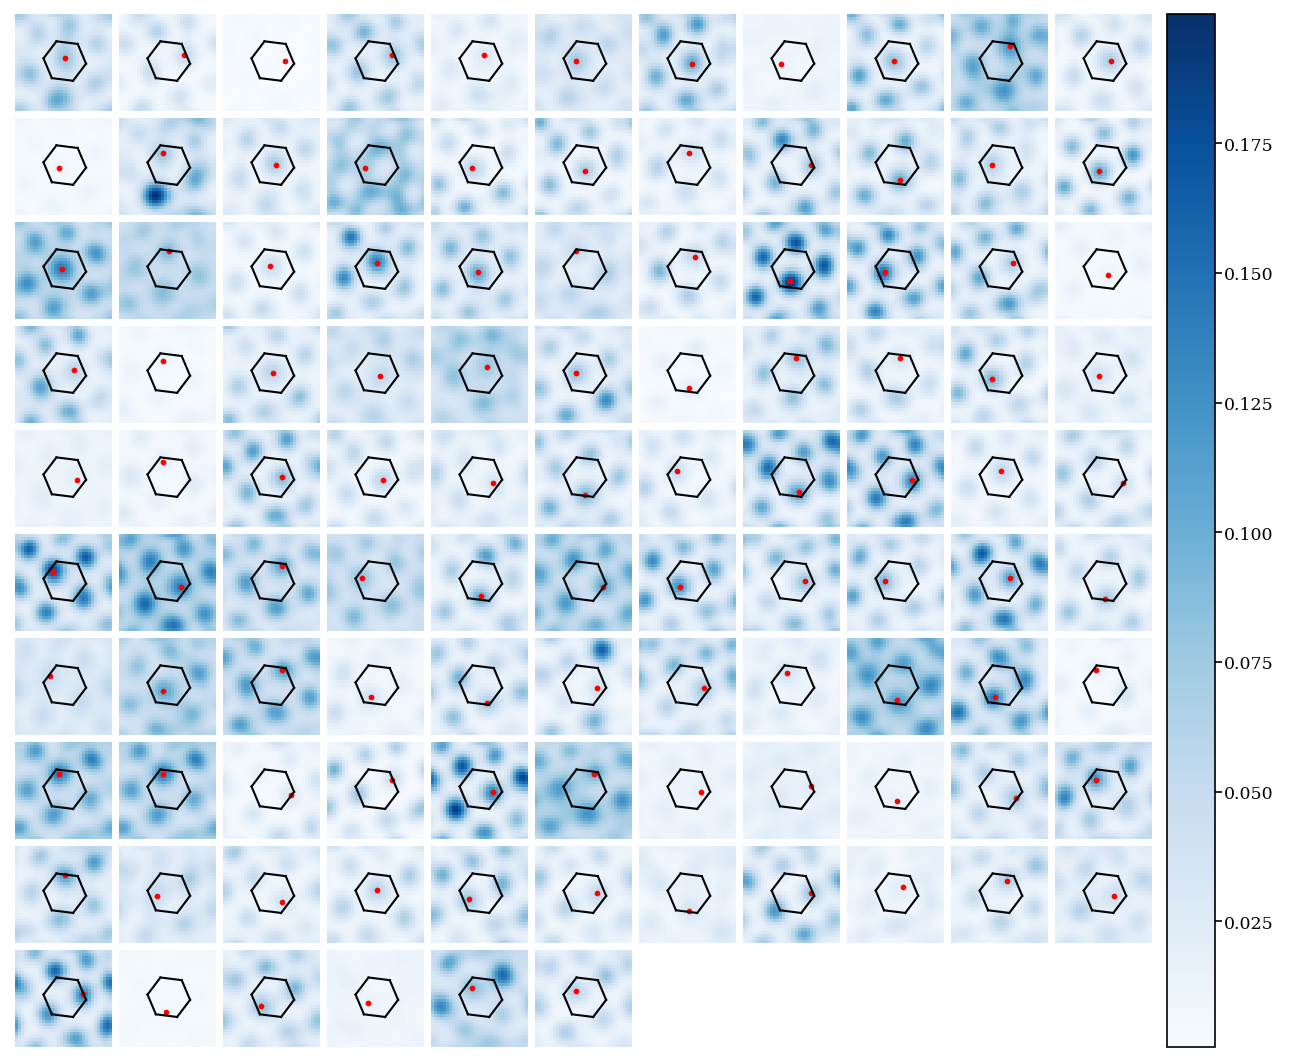

In [124]:
from plotting_functions import multiimshow
fig, axs = multiimshow(ratemaps[np.argsort(grid_scores)[::-1]].transpose(0,2,1), 
                       origin='lower', figsize=(8,8), normalize=True, add_colorbar=True);
for i in range(len(center_peaks)):
    axs[i].scatter(*center_peaks[np.argsort(grid_scores)[::-1]][i], color='red', s=3)
    #hexagon.unit_cell.plot(fig, axs[i], center=center_peaks[np.argsort(grid_scores)[::-1]][i], color='black')
    hexagon.unit_cell.plot(fig, axs[i], center=np.ones(2)*res/2, color='black')

fig.savefig('./results/experimental-phases.png', dpi=400, bbox_inches='tight')

## KDE, Ripley and Grid score of phases

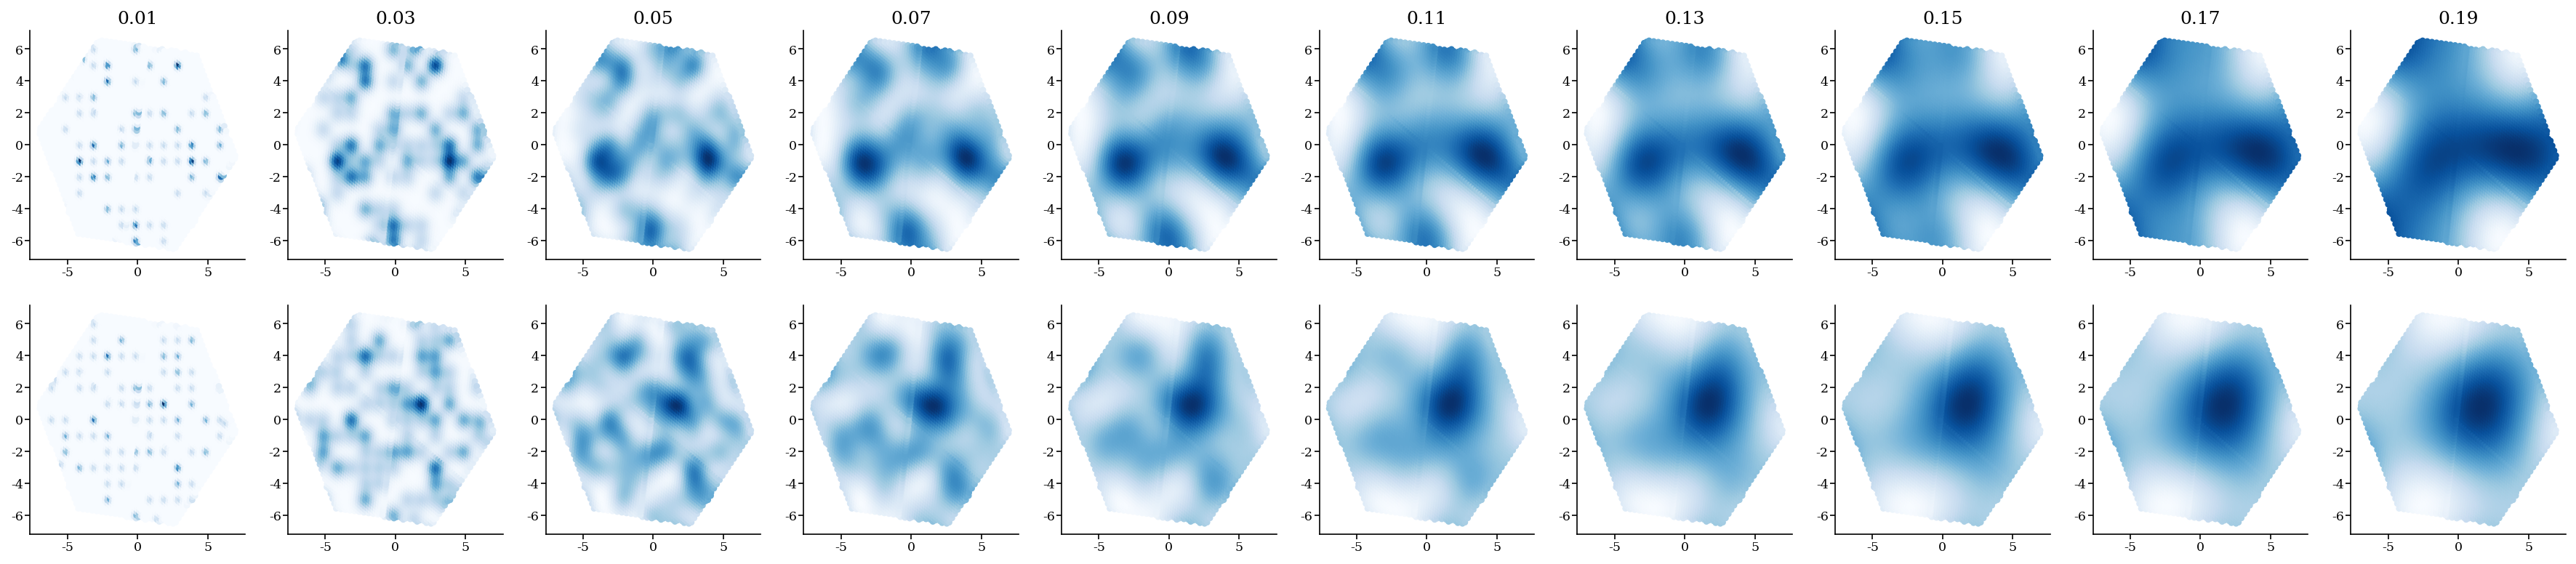

In [16]:
bw_method = np.linspace(0, 0.2, 21)[1:]#hexagon.unit_cell.radius/2/10, 21)[1:]
fig, axs = plt.subplots(nrows=2, ncols=len(bw_method)//2, figsize=(len(bw_method)//2*3, 3*2))
for i, r in enumerate(bw_method[::2]):
    kde, mesh, _, _ = hexagon.phase_kde(bw_method=r, res=64)
    axs[0,i].scatter(*mesh.T, c=kde, s=10)
    axs[0,i].set_title(f'{r:.2f}')


for i, r in enumerate(bw_method[::2]):
    kde, mesh, _, _ = random_hexagon.phase_kde(bw_method=r, res=64)
    axs[1,i].scatter(*mesh.T, c=kde, s=10)

In [17]:
from models import JacobianCI
ci_model = JacobianCI(ncells=7,lr=1e-3, seed=3, f=2/(3*radius*1.4), init_rot=orientation)
ci_model_small = JacobianCI(ncells=7,lr=1e-3, seed=3, f=f, init_rot=orientation)
loss_history = ci_model.train_model(ntrain_steps=5000)
_ = ci_model_small.train_model(ntrain_steps=5000)


100%|██████████| 5000/5000 [00:06<00:00, 773.99it/s]


(-10.853654217998194,
 10.853654217998193,
 -10.078468626163351,
 10.07846862616335)

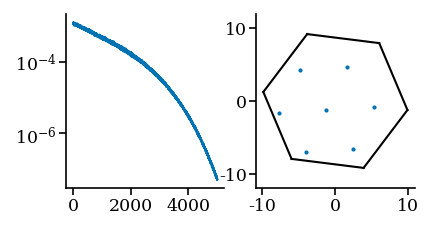

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(3, 1.5))
axs[0].semilogy(loss_history)
ci_model.unit_cell.plot(fig=fig, ax=axs[1], color='black')
axs[1].scatter(*ci_model.phases.detach().numpy().T,s=1)
axs[1].axis('equal')
#ax.axis('off')

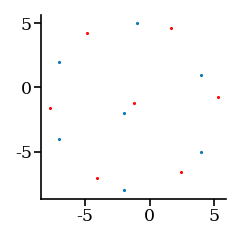

In [19]:
from utils import find_peaks
import torch

rel_box_size = radius * res / radius

x = np.linspace(-rel_box_size/2,rel_box_size/2,res)
y = np.linspace(-rel_box_size/2,rel_box_size/2,res)
X,Y = np.meshgrid(x,y)
square_mesh = np.stack([X,Y],axis=-1)
square_mesh.shape

# calculate ratemaps with given resolution and find peaks in the sqaure mesh
ci_ratemaps = ci_model(torch.tensor(square_mesh.reshape(-1,2),
                                    dtype=torch.float32)).detach().numpy().reshape(res,res,-1)
ci_center_peaks = np.array([find_peaks(ci_ratemaps[:,:,i])[0] for i in range(ci_ratemaps.shape[-1])])
# convert peaks to unit cell coordinates again
ci_center_peaks = ci_center_peaks / res * rel_box_size - rel_box_size/2

plt.scatter(*ci_center_peaks.T)
plt.scatter(*ci_model.phases.detach().numpy().T, color='red')

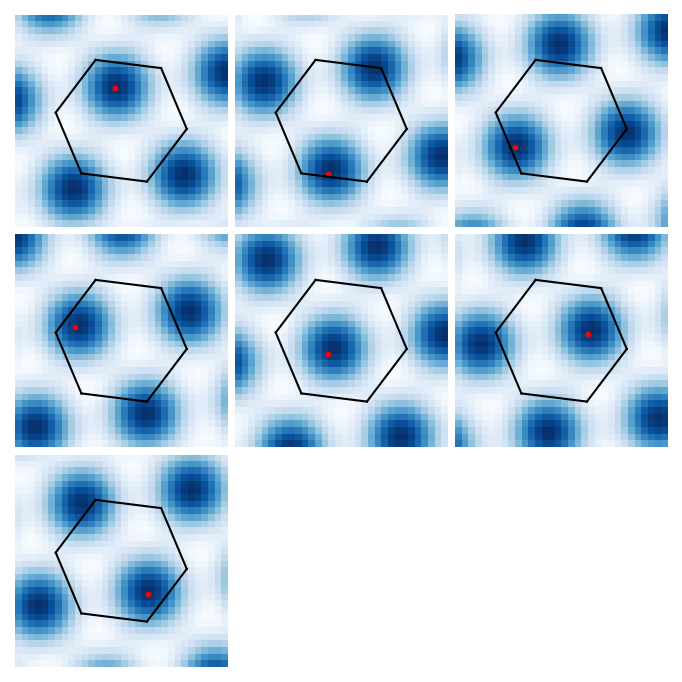

In [20]:
fig, axs = multiimshow(ci_ratemaps.transpose(2,1,0), origin='lower', figsize=(5,5), normalize=False, 
                       extent=(-rel_box_size/2,rel_box_size/2,-rel_box_size/2,rel_box_size/2));
for i in range(len(ci_center_peaks)):
    axs[i].scatter(*ci_center_peaks[i], color='red', s=3)
    ci_model.unit_cell.plot(fig, axs[i], center=np.zeros(2), color='black')

In [21]:
import copy
#ci_center_peaks = ci_center_peaks[:,None] + np.random.normal(0, 10, size=(ratemaps.shape[0]//7,2))[None]
#ci_center_peaks = ci_model.phases.detach().numpy()[:,None] +  ci_model.unit_cell.sample(ratemaps.shape[0]//7)[None]
ci_center_peaks = ci_model.phases.detach().numpy()[:,None] + np.random.normal(0, 1.4, size=(ratemaps.shape[0]//7,2))[None]
ci_center_peaks = ci_center_peaks.reshape(-1,2)
ci_center_peaks = np.around(ci_model.unit_cell.wrap(ci_center_peaks))
#ci_center_peaks = ci_model.unit_cell.wrap(ci_center_peaks)
ci_center_peaks.shape

(105, 2)

In [22]:
tmp_phase = ci_model_small.phases.detach().numpy()[:,None] + np.random.normal(0, 1.4, size=(ratemaps.shape[0]//7,2))[None]
tmp_phase = tmp_phase.reshape(-1,2)
tmp_phase = ci_model.unit_cell.wrap(tmp_phase)
ci_model_small.set_phases(tmp_phase)
ci_model_small.set_scale()
ci_cpy_ratemaps = ci_model_small(torch.tensor(square_mesh.reshape(-1,2),
                                    dtype=torch.float32)).detach().numpy().reshape(res,res,-1)

random_ratemaps = random_hexagon(torch.tensor(square_mesh.reshape(-1,2),
                                    dtype=torch.float32)).detach().numpy().reshape(res,res,-1)

In [23]:
kde_data, mesh, _, _ = hexagon.phase_kde(bw_method=0.09, res=64)#,wrap=False,double_extension=False)
kde_random, mesh, _, _ = random_hexagon.phase_kde(bw_method=0.09, res=64)#,wrap=False,double_extension=False)
kde_ci, mesh_ci, _, _ = ci_model.phase_kde(bw_method=0.09, res=64)
min_kde = min(kde_data.min(), kde_random.min(), kde_ci.min())
max_kde = max(kde_data.max(), kde_random.max(), kde_ci.max())
min_kde, max_kde

(0.00012329160348516175, 0.0006807987532863247)

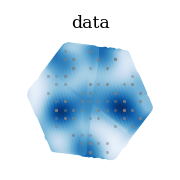

In [24]:
fig, ax = plt.subplots(figsize=(1,1))
phase_grid_score = hexagon.grid_score(bw_method=0.11)
ax.scatter(*mesh.T, c=kde_data, s=10, vmin=min_kde, vmax=max_kde)
ax.scatter(*(center_peaks-res/2).T,alpha=0.5,color='grey')
ax.set_title('data',fontsize='small')
ax.axis('off')
ax.axis('equal')
# add colorbar
#cbar = plt.colorbar(ax.collections[0], ax=ax)#, orientation='horizontal')

fig.tight_layout(pad=0)
fig.savefig('./results/hexagon_phase_kde.pdf')

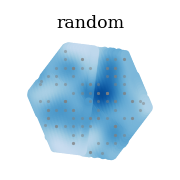

In [25]:
fig, ax = plt.subplots(figsize=(1,1))
ax.scatter(*mesh.T, c=kde_random, s=10, vmin=min_kde, vmax=max_kde)
ax.scatter(*random_hexagon.phases.detach().numpy().T,alpha=0.5,color='grey')
ax.set_title('random',fontsize='small')
ax.axis('off')
ax.axis('equal')

fig.tight_layout(pad=0)
fig.savefig('./results/random_hexagon_phase_kde.pdf')

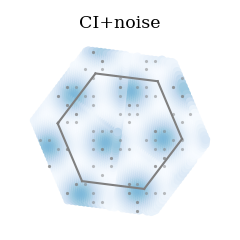

In [117]:
fig,ax = plt.subplots(figsize=(1*1.4,1*1.4))
fig, ax = hexagon.unit_cell.plot(color='grey', fig=fig, ax=ax)
ax.scatter(*mesh_ci.T, c=kde_ci, s=10, vmin=min_kde, vmax=max_kde)
ax.scatter(*ci_center_peaks.T,alpha=0.5,color='grey')
ax.axis('equal')
ax.axis('off')
ax.set_title('CI+noise',fontsize='small')

fig.tight_layout(pad=0)
fig.savefig('./results/ci_phase_kde.pdf')

In [27]:
radii = np.linspace(0, hexagon.unit_cell.radius-1e-6, 32)[1:]
random_ripleys = []
ci_ripleys = []
for _ in tqdm.trange(100):
    random_hexagon.set_phases(np.around(random_hexagon.unit_cell.wrap(random_hexagon.unit_cell.sample(len(center_peaks)))))
    random_ripleys_i = [random_hexagon.ripleys(r) for r in radii]
    random_ripleys.append(random_ripleys_i)
    ci_center_peaks = ci_model.phases.detach().numpy()[:,None] + np.random.normal(0, 1.4, size=(ratemaps.shape[0]//7,2))[None]
    ci_center_peaks = ci_center_peaks.reshape(-1,2)
    ci_center_peaks = np.around(ci_model.unit_cell.wrap(ci_center_peaks))
    ci_ripleys_i = [ci_model.ripleys(r,phases=ci_center_peaks) for r in radii]
    ci_ripleys.append(ci_ripleys_i)
random_ripleys = np.array(random_ripleys)
ci_ripleys = np.array(ci_ripleys)

100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


In [28]:
ripleys = [hexagon.ripleys(r) for r in radii]
#ci_ripleys = [ci_model.ripleys(r,phases=ci_center_peaks) for r in radii]
ripleys = np.array(ripleys)

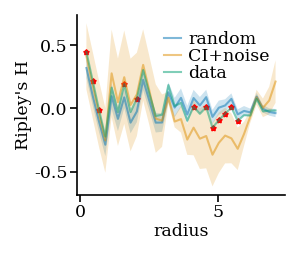

In [29]:
fig=plt.figure(figsize = (1.8,1.5))

# random baseline
plt.plot(radii, np.mean(random_ripleys, axis=0), label = "random", alpha=0.5)
mu_random = np.mean(random_ripleys, axis=0)
sigma_random = np.std(random_ripleys, axis=0)
plt.fill_between(radii, mu_random - 2*sigma_random, mu_random + 2*sigma_random, alpha=0.2)
# hexagonal baseline
#plt.plot(radii, ci_ripleys, label = "Optimised", alpha=0.5)
# hexagonal baseline
plt.plot(radii, np.mean(ci_ripleys, axis=0), label = "CI+noise", alpha=0.5)
mu_optimised = np.mean(ci_ripleys, axis=0)
sigma_optimised = np.std(ci_ripleys, axis=0)
plt.fill_between(radii, mu_optimised - 2*sigma_optimised, mu_optimised + 2*sigma_optimised, alpha=0.2)
# data
plt.plot(radii, ripleys, label = "data",alpha=0.5)
# plot star where significant
plt.scatter(radii[ripleys > mu_random + 2*sigma_random], 
            ripleys[ripleys > mu_random + 2*sigma_random], color='red', marker='*', s=5)
plt.scatter(radii[ripleys < mu_random -2*sigma_random], 
            ripleys[ripleys < mu_random-2*sigma_random], color='red', marker='*', s=5)

#plt.axvline(2/(ci_model.f*np.sqrt(21)), color='grey', linestyle='--', label=r'$2/f\sqrt{21}$')

plt.xlabel('radius', fontsize='small')
plt.ylabel('Ripley\'s H', fontsize='small')
plt.legend(frameon = False, fontsize='small')

fig.tight_layout(pad=0)
fig.savefig('./results/ripleys.pdf')#, dpi=300)

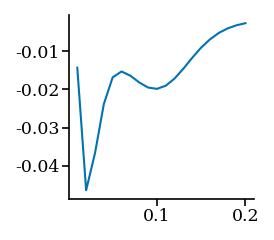

In [30]:
grid_scores = [hexagon.grid_score(bw_method=r) for r in bw_method]
plt.plot(bw_method, grid_scores)

**We want to** find the distance between two neighbouring small hexagons centers, i.e. $2a_p$. This gives us an expectation for when the ripleys would change from below random expectation to above random expectation of phases in a given ball radius, in the scenario where the phases where hexagonally arranged.

We have the frequency of the generating pattern is $f=\frac{2}{3R}$, where $R$ is the radius of the corresponding unit cell. The apothem $A_p$ of the unit cell can be calculated from the special triangle (30-60-90 triangle) with side lengths (from long to short) as $R, A_p, R/2$. This gives

\begin{align}
R^2 &= A_p^2 + \left(\frac{R}{2}\right)^2 \\
A_p  &= \frac{\sqrt{3}}{2}R
\end{align}

We further have that the unit cell can have a good cover with 7 regular hexagons. The area of each of these subhexagons are $a = \frac{1}{7}A$ of the size of the area of the unit cell hexagon. The area of a hexagon is in general given by $A = \frac{3\sqrt(3)R^2}{2}$. So get we

\begin{align}
a &= \frac{1}{7}A \\
\frac{3\sqrt(3)r^2}{2} &= \frac{1}{7} \cdot \frac{3\sqrt(3)R^2}{2} \\
r &= \frac{1}{\sqrt{7}}R
\end{align}

Since $A_p$ is proportional to $R$, we also have $a_p = \frac{1}{\sqrt{7}} A_p$ 

This gives $2a_p$, in terms of $f$

\begin{align}
2a_p = 2\cdot\frac{1}{\sqrt{7}} A_p = \frac{2}{\sqrt{7}}\cdot \frac{\sqrt{3}}{2}R = \frac{\sqrt{3}}{\sqrt{7}}\cdot \frac{2}{3f} = \frac{2}{f\sqrt{21}}
\end{align}

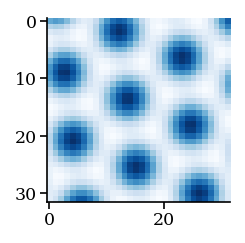

In [31]:
plt.imshow(random_ratemaps[:,:,0])

In [32]:
np.min(ci_ratemaps), np.max(ci_ratemaps), np.min(ratemaps), np.max(ratemaps)

(7.942319e-05, 0.9998579, 0.0007648547037022709, 0.19987294062402394)

In [33]:
ncells = len(ratemaps)
dist = np.linalg.norm(ratemaps.reshape(ncells,res**2)[:,None] - 
                      ratemaps.reshape(ncells,res**2)[...,None],axis=0)


ci_cpy_dist = np.linalg.norm(ci_cpy_ratemaps.reshape(res**2,-1).T[:,None] -
                            ci_cpy_ratemaps.reshape(res**2,-1).T[...,None],axis=0)

random_dist = np.linalg.norm(random_ratemaps.reshape(res**2,-1).T[:,None] -
                            random_ratemaps.reshape(res**2,-1).T[...,None],axis=0)

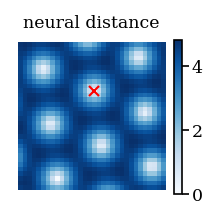

In [34]:
row = 10
col = 16
a = row*32 + col
fig,ax = plt.subplots(figsize = (1.25,1.25))
im = ax.imshow(ci_cpy_dist[a].reshape(res,res))
plt.plot(col,row, "rx", markersize = 5)
# add colorbar that fits the image and doesnt stretch beyond
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.axis('off')
ax.axis('equal')
ax.set_title('neural distance',fontsize='small')
plt.tight_layout(pad=0)
fig.savefig('./results/neural_distance.pdf')

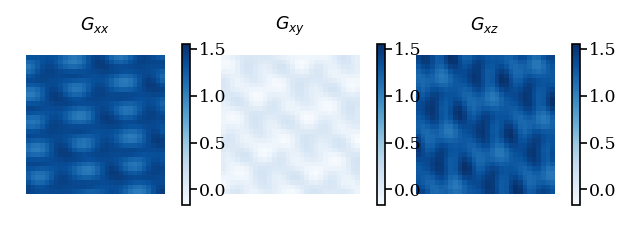

In [35]:
grads = np.array([np.gradient(im) for im in random_ratemaps.transpose(2,0,1)])
grads = np.transpose(grads, (0, -2, -1, 1))
grads = grads[:, 1:-1, 1:-1] # remove 1st order boundary term

fig, axs = plt.subplots(1, 3, figsize = (3.9,1.3))

m11 = np.sum(grads[...,0]**2, axis = 0)
m22 = np.sum(grads[...,1]**2, axis = 0)
m12 = np.sum(grads[...,0]*grads[...,1], axis = 0)

vmin = min(m11.min(), m22.min(), m12.min())
vmax = max(m11.max(), m22.max(), m12.max())

im1 = axs[0].imshow(m11, vmin=vmin, vmax=vmax)
im2 = axs[1].imshow(m12, vmin=vmin, vmax=vmax)
im3 = axs[2].imshow(m22, vmin=vmin, vmax=vmax)
[ax.axis("off") for ax in axs]
[ax.axis("equal") for ax in axs]
[ax.set_title(title,fontsize='small') for ax, title in zip(axs, ["$G_{xx}$", "$G_{xy}$", "$G_{xz}$"])]
[fig.colorbar(im, ax = ax, fraction=0.046, pad=0.04) for ax, im in zip(axs, [im1, im2, im3])]
plt.tight_layout(pad=0)
fig.savefig('./results/metric_tensor_components.pdf')

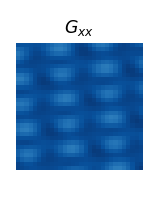

In [36]:
fig,ax = plt.subplots(figsize = (0.85,1.25))
im1 = ax.imshow(m11, vmin=vmin, vmax=vmax)
ax.axis('off')
ax.axis('equal')
ax.set_title("$G_{xx}$",fontsize='small',y=0.85)
#fig.colorbar(im1, ax = ax, fraction=0.046, pad=0.04)
fig.tight_layout(pad=0)
fig.savefig('./results/metric_tensor_components11.pdf')

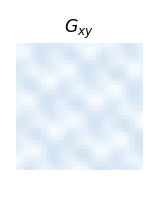

In [37]:
fig,ax = plt.subplots(figsize = (0.85,1.25))
im1 = ax.imshow(m12, vmin=vmin, vmax=vmax)
ax.axis('off')
ax.axis('equal')
ax.set_title("$G_{xy}$",fontsize='small',y=0.85)
#fig.colorbar(im1, ax = ax, fraction=0.046, pad=0.04)
fig.tight_layout(pad=0)
fig.savefig('./results/metric_tensor_components12.pdf')

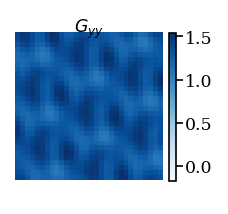

In [38]:
fig,ax = plt.subplots(figsize = (1.32,1.25))
im1 = ax.imshow(m22, vmin=vmin, vmax=vmax)
ax.axis('off')
ax.axis('equal')
ax.set_title("$G_{yy}$",fontsize='small',y=0.85)
fig.colorbar(im1, ax = ax, fraction=0.046, pad=0.04)
fig.tight_layout(pad=0)
fig.savefig('./results/metric_tensor_components22.pdf')

In [39]:
# shuffled distribution (space)
n_shuffles = 1000

a = []
b = []
c = []

for i in range(n_shuffles):
    abx = np.copy(ratemaps).reshape(-1, res*res) # shuffle ratemaps
    abx = abx[:, np.random.choice(res*res, size = res*res, replace = False)]
    abx = abx.reshape(-1, res, res)
    grads = np.array([np.gradient(im) for im in abx])

    grads = np.transpose(grads, (0, -2, -1, 1))
    grads = grads[:, 1:-1, 1:-1] # remove 1st order boundary term

    a.append(np.sum(grads[...,0]**2, axis=0))
    b.append(np.sum(grads[...,1]**2, axis = 0))
    c.append(np.sum(grads[...,1]*grads[...,0], axis = 0))

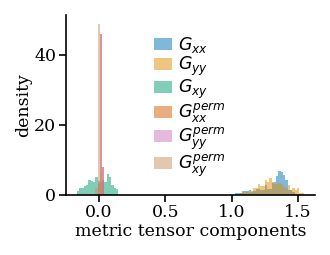

In [40]:
fig,ax = plt.subplots(figsize = (2,1.5))
bins = np.linspace(np.min([m11.min(), m22.min(), m12.min(), 
                           np.array(a).min(), np.array(b).min(), np.array(c).min()]), 
                           np.max([m11.max(), m22.max(), m12.max(), np.array(a).max(), 
                                   np.array(b).max(), np.array(c).max()]), 100)
ax.hist(m11.ravel(), label = "$G_{xx}$", alpha = 0.5, density=True,bins=bins)
ax.hist(m22.ravel(), label = "$G_{yy}$", alpha = 0.5, density=True, bins=bins)
ax.hist(m12.ravel(), label = "$G_{xy}$", alpha = 0.5, density=True, bins=bins)

ax.hist(np.array(a).ravel(), label = "$G^{perm}_{xx}$", alpha = 0.5, density=True, bins=bins)
ax.hist(np.array(b).ravel(), label = "$G^{perm}_{yy}$", alpha = 0.5, density=True, bins=bins)
ax.hist(np.array(c).ravel(), label = "$G^{perm}_{xy}$", alpha = 0.5, density=True, bins=bins)
ax.legend(frameon = False)

ax.set_xlabel('metric tensor components',fontsize='small')
ax.set_ylabel('density',fontsize='small')

fig.tight_layout(pad=0)
fig.savefig('./results/metric_tensor_components_hist.pdf')

In [41]:
ci_ratemaps.shape

(32, 32, 7)

In [42]:
x = np.linspace(0, 1.5, res) # in meters
y = np.copy(x)
xx, yy = np.meshgrid(x, y)
rr = np.stack((xx.ravel(), yy.ravel()), axis = -1)
dr = np.linalg.norm(rr[:,None] - rr[None], axis = -1)

flat_maps = ratemaps.reshape(-1, res*res)
dg = np.linalg.norm(flat_maps.T[:,None] - flat_maps.T[None], axis = -1)

flat_maps_ci_cpy = ci_cpy_ratemaps.reshape(res**2, -1)
dgi = np.linalg.norm(flat_maps_ci_cpy[:,None] - flat_maps_ci_cpy[None], axis = -1)

abx2 = np.reshape(abx, (-1, res*res)).T
dn = np.linalg.norm(abx2[:,None] - abx2[None], axis = -1)

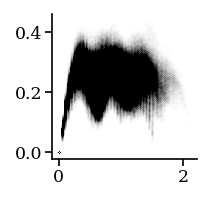

In [43]:
plt.figure(figsize=(1.25,1.25))
plt.scatter(dr.ravel(), dg.ravel(), alpha = 0.005, s = 0.1, c = "k")

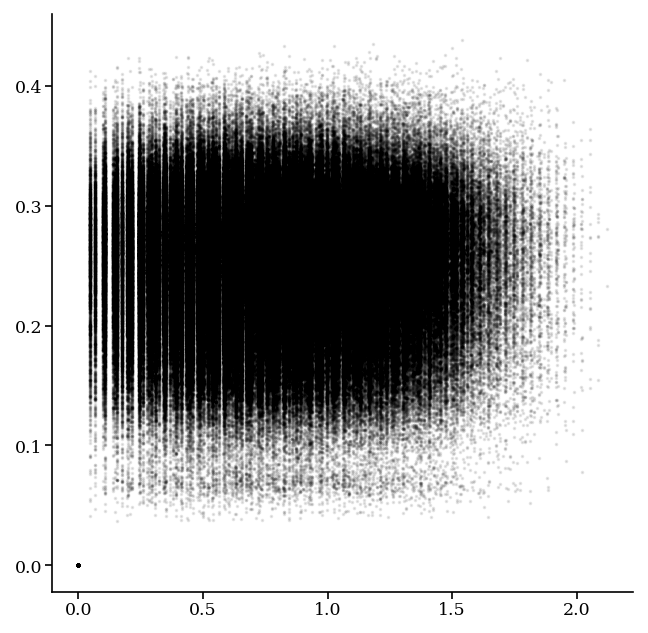

In [44]:
plt.figure(figsize=(5,5))
plt.scatter(dr.ravel(), dn.ravel(), alpha = 0.05, s = 0.5, c = "k")

In [94]:
x = np.linspace(0, 1.5, res) # in meters
y = np.copy(x)
xx, yy = np.meshgrid(x, y)
rr = np.stack((xx.ravel(), yy.ravel()), axis = -1)
dr = scipy.spatial.distance.pdist(rr)

flat_maps = ratemaps.reshape(-1, res*res)
# dg = np.linalg.norm(flat_maps.T[:,None] - flat_maps.T[None], axis = -1)
dg = scipy.spatial.distance.pdist(flat_maps.T)

flat_maps_ci_cpy = ci_cpy_ratemaps.reshape(res**2, -1)
dgi = scipy.spatial.distance.pdist(flat_maps_ci_cpy)

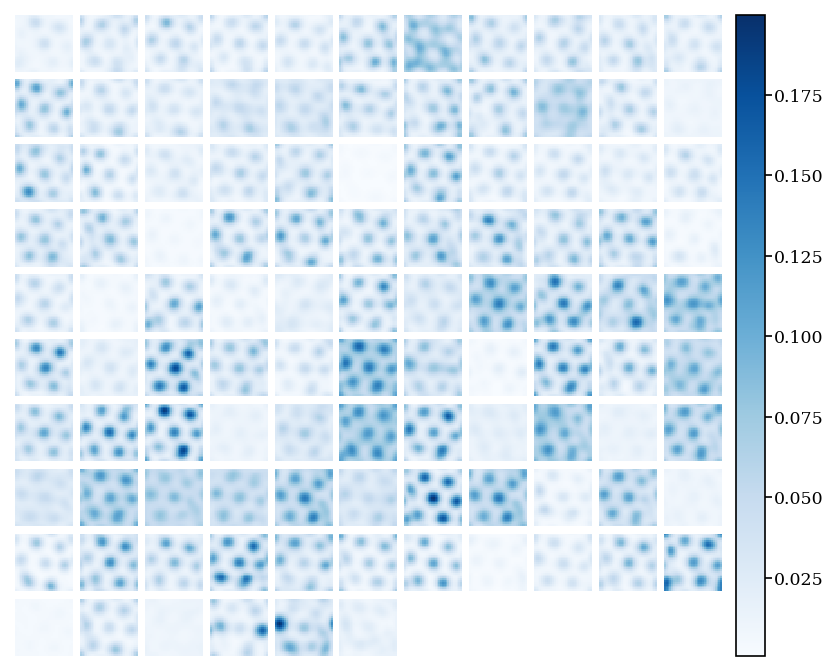

In [136]:
# rolled baseline
rolled = np.array([np.roll(ratemaps[i], -(center_peaks[i] - res//2), axis = (-2, -1)) for i in range(len(ratemaps))])
rolled = np.array([np.roll(ratemaps[i], -(center_peaks[i] - res//2), axis = (-2, -1)) for i in range(len(ratemaps))])
multiimshow(rolled,figsize = (5,5));
rolled = np.reshape(rolled, (-1, res*res)).T
droll = scipy.spatial.distance.pdist(rolled)

In [96]:
def shuffle_ratemap_distances(ratemaps, n_shuffles = 100):
    
    dns = []
    res = ratemaps.shape[-1]

    for i in range(n_shuffles):
        shuffled = np.copy(ratemaps).reshape(-1, res*res) # shuffle ratemaps
        inds = np.random.choice(res*res, size = res*res, replace = False)
        shuffled = shuffled[:, inds]
        shuffled = np.reshape(shuffled, (-1, res*res)).T
        dn = scipy.spatial.distance.pdist(shuffled)
        dns.append(dn)

    return np.array(dns)

In [97]:
# Data
hist_g, xedges_g, _ = scipy.stats.binned_statistic(dr.ravel(), dg.ravel(), "mean", bins = 32)
std_g, _, _ = scipy.stats.binned_statistic(dr.ravel(), dg.ravel(), "std", bins = xedges_g)

# Shuffled
dns = shuffle_ratemap_distances(ratemaps)
dr = scipy.spatial.distance.pdist(rr)
drs = np.array([dr for i in range(len(dns))])

hist_n, xedges_n, _ = scipy.stats.binned_statistic(drs.ravel(), dns.ravel(), "mean", bins = 32)
std_n, _, _ = scipy.stats.binned_statistic(drs.ravel(), dns.ravel(), "std", bins = xedges_n)

# Rolled
hist_r, xedges_r, _ = scipy.stats.binned_statistic(dr.ravel(), droll.ravel(), "mean", bins = 32)
std_r, _, _ = scipy.stats.binned_statistic(dr.ravel(), droll.ravel(), "std", bins = xedges_r)


xg = xedges_g[:-1] + np.diff(xedges_g)/2 # plot vs. center of bin
xn = xedges_n[:-1] + np.diff(xedges_n)/2 
xr = xedges_r[:-1] + np.diff(xedges_r)/2 

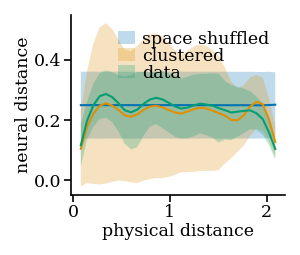

In [115]:
fig, ax = plt.subplots(figsize = (1.8,1.5))

# shuffled
ax.plot(xn, hist_n)
ax.fill_between(xn, hist_n - 2*std_n, hist_n + 2*std_n, alpha = 0.25, label = "space shuffled")

# rolled
ax.plot(xr, hist_r)
ax.fill_between(xr, hist_r - 2*std_r, hist_r + 2*std_r, alpha = 0.25, label = "clustered")

# data
ax.plot(xg, hist_g)
ax.fill_between(xg, hist_g - 2*std_g, hist_g + 2*std_g, alpha = 0.25, label = "data")

ax.legend(frameon = False, fontsize='small')
ax.set_xlabel("physical distance", fontsize = 'small')
ax.set_ylabel("neural distance", fontsize = 'small')

fig.tight_layout(pad=0)
fig.savefig('./results/distance_correlation.pdf')